In [1]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import tqdm
import shutil

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip "/content/drive/MyDrive/dogs-vs-cats.zip" -d "/content/dogs-vs-cats"

Archive:  /content/drive/MyDrive/dogs-vs-cats.zip
  inflating: /content/dogs-vs-cats/sampleSubmission.csv  
  inflating: /content/dogs-vs-cats/test1.zip  
  inflating: /content/dogs-vs-cats/train.zip  


In [4]:
!unzip "/content/dogs-vs-cats/train.zip" -d "/content/dogs-vs-cats"
!unzip "/content/dogs-vs-cats/test1.zip" -d "/content/dogs-vs-cats"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dogs-vs-cats/test1/5499.jpg  
  inflating: /content/dogs-vs-cats/test1/55.jpg  
  inflating: /content/dogs-vs-cats/test1/550.jpg  
  inflating: /content/dogs-vs-cats/test1/5500.jpg  
  inflating: /content/dogs-vs-cats/test1/5501.jpg  
  inflating: /content/dogs-vs-cats/test1/5502.jpg  
  inflating: /content/dogs-vs-cats/test1/5503.jpg  
  inflating: /content/dogs-vs-cats/test1/5504.jpg  
  inflating: /content/dogs-vs-cats/test1/5505.jpg  
  inflating: /content/dogs-vs-cats/test1/5506.jpg  
  inflating: /content/dogs-vs-cats/test1/5507.jpg  
  inflating: /content/dogs-vs-cats/test1/5508.jpg  
  inflating: /content/dogs-vs-cats/test1/5509.jpg  
  inflating: /content/dogs-vs-cats/test1/551.jpg  
  inflating: /content/dogs-vs-cats/test1/5510.jpg  
  inflating: /content/dogs-vs-cats/test1/5511.jpg  
  inflating: /content/dogs-vs-cats/test1/5512.jpg  
  inflating: /content/dogs-vs-cats/test1/5513.jpg  
  inflating: /con

In [5]:
base_dir = "/content/dogs-vs-cats"
train_dir = "/content/dogs-vs-cats/train"

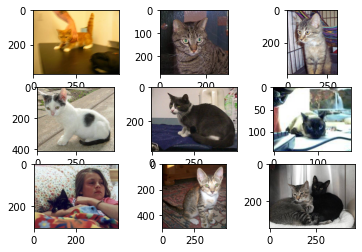

In [6]:
from matplotlib import pyplot
from matplotlib.image import imread
# define location of dataset
folder = train_dir + '/'
# plot first few images
for i in range(9):
	# define subplot
    pyplot.subplot(330 + 1 + i)
	# define filename
    filename = folder + 'cat.' + str(i) + '.jpg'
	# load image pixels
    image = imread(filename)
	# plot raw pixel data
    pyplot.imshow(image)
# show the figure
pyplot.show()

/content/dogs-vs-cats/train/dog.0.jpg
/content/dogs-vs-cats/train/dog.1.jpg
/content/dogs-vs-cats/train/dog.2.jpg
/content/dogs-vs-cats/train/dog.3.jpg
/content/dogs-vs-cats/train/dog.4.jpg
/content/dogs-vs-cats/train/dog.5.jpg
/content/dogs-vs-cats/train/dog.6.jpg
/content/dogs-vs-cats/train/dog.7.jpg
/content/dogs-vs-cats/train/dog.8.jpg


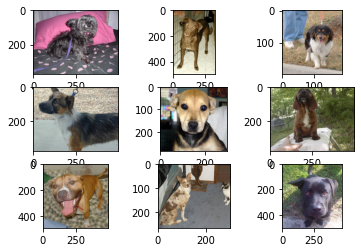

In [7]:
from matplotlib import pyplot
from matplotlib.image import imread
# define location of dataset
folder = train_dir + '/'
# plot first few images
for i in range(9):
	# define subplot
    pyplot.subplot(330 + 1 + i)
	# define filename
    filename = folder + 'dog.' + str(i) + '.jpg'
    
	# load image pixels
    print(filename)
    
    image = imread(filename)
   
	# plot raw pixel data
    pyplot.imshow(image)
    # show the figure

pyplot.show()

In [8]:
train_file_list = os.listdir("/content/dogs-vs-cats/train")
print('Num of images:', len(train_file_list))

dog_filenames = [fn for fn in train_file_list if fn.startswith('dog')]
cat_filenames = [fn for fn in train_file_list if fn.startswith('cat')]

dataset_filenames = train_test_split(
    dog_filenames, cat_filenames, test_size=0.1, shuffle=True, random_state=42
)


train_dog, valid_dog, train_cat, valid_cat  = [fns for fns in dataset_filenames]


train_dog_total, valid_dog_total, train_cat_total, valid_cat_total = [len(fns) for fns in dataset_filenames]
train_total = train_dog_total + train_cat_total
valid_total = valid_dog_total + valid_cat_total
print('Train: {}, test: {}'.format(train_total, valid_total))

Num of images: 25000
Train: 22500, test: 2500


In [9]:
TRAIN_DIR_DOG = train_dir + '/dog'
TRAIN_DIR_CAT = train_dir + '/cat'
valid_dir = base_dir + '/valid'
VALID_DIR_DOG = valid_dir + '/dog'
VALID_DIR_CAT = valid_dir + '/cat'

In [10]:
make_dirs = [TRAIN_DIR_DOG, VALID_DIR_DOG, TRAIN_DIR_CAT, VALID_DIR_CAT]
for dir, fns in zip(make_dirs, dataset_filenames):
    os.makedirs(dir, exist_ok=True)
    for fn in tqdm.tqdm(fns):
        shutil.move(os.path.join(train_dir, fn), dir)

100%|██████████| 1250/1250 [00:00<00:00, 30069.45it/s]


In [11]:
!ls ../content/dogs-vs-cats/train

cat  dog


In [12]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized to 224x224
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        valid_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary')

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [13]:
mobile_net_layers = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(224,224,3))
mobile_net_layers.trainable= False

17225924/17225924 [==============================] - 0s 0us/step


In [14]:
model = tf.keras.Sequential([
  mobile_net_layers,
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1,activation='sigmoid')
])

In [15]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [16]:
history = model.fit(
      train_generator,
      steps_per_epoch=32, 
      epochs=20,
      validation_data=validation_generator,
      validation_steps=32, 
      verbose=1)

Epoch 1/20
32/32 [==============================] - 30s 920ms/step - loss: 0.7206 - accuracy: 0.8781 - val_loss: 0.2028 - val_accuracy: 0.9688
Epoch 2/20
32/32 [==============================] - 29s 904ms/step - loss: 0.2478 - accuracy: 0.9594 - val_loss: 0.3534 - val_accuracy: 0.9563
Epoch 3/20
32/32 [==============================] - 29s 906ms/step - loss: 0.1995 - accuracy: 0.9766 - val_loss: 0.0718 - val_accuracy: 0.9812
Epoch 4/20
32/32 [==============================] - 28s 901ms/step - loss: 0.1025 - accuracy: 0.9797 - val_loss: 0.0981 - val_accuracy: 0.9828
Epoch 5/20
32/32 [==============================] - 29s 905ms/step - loss: 0.1452 - accuracy: 0.9797 - val_loss: 0.1250 - val_accuracy: 0.9766
Epoch 6/20
32/32 [==============================] - 28s 903ms/step - loss: 0.1377 - accuracy: 0.9844 - val_loss: 0.1032 - val_accuracy: 0.9781
Epoch 7/20
32/32 [==============================] - 28s 899ms/step - loss: 0.2573 - accuracy: 0.9734 - val_loss: 0.2378 - val_accuracy: 0.9531

In [17]:
model.save('model_tf')

In [18]:
!pip install onnxruntime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 93.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 KB 13.3 MB/s eta 0:00:00


In [19]:
!pip install tf2onnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.3/442.3 KB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 59.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 76.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
tensorboard 2.9.1 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.


In [20]:
import onnx
import tf2onnx
import tensorflow as tf

In [21]:
import os
path = "/content/model_onnx"
os.mkdir(path)

In [22]:
MODEL_TF_DIR = "model_tf"
MODEL_TF2ONNX_DIR = "model_onnx/model.onnx"

In [23]:
#Load tf model
model = tf.keras.models.load_model("model_tf")

#Convert tf model to onnx model using tf2onnx library.
onnx_model, _ = tf2onnx.convert.from_keras(model, opset=13)

#Save onnx model to onnx directory.
try:
    onnx.save(onnx_model, MODEL_TF2ONNX_DIR)
    print("Save onnx model successfully")
except Exception as ex:
    print("Failed to save onnx model")
    print(ex)

Save onnx model successfully


In [24]:
import numpy as np
import matplotlib.pyplot as plt

<class 'numpy.ndarray'>
(224, 224, 3)


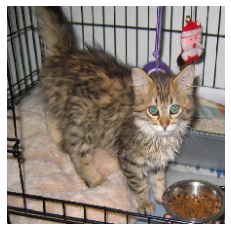

In [25]:
image = tf.keras.utils.load_img("/content/dogs-vs-cats/test1/10019.jpg", target_size=(224,224,3))
plt.imshow(image)
plt.axis('off')
test = tf.keras.utils.img_to_array(image)
print(type(test))
print(test.shape)
test = test/255.
test = np.expand_dims(test,0)

In [26]:
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
if(model.predict(test) < 0.5): 
  print("cat")
else: 
  print("dog")

1/1 [==============================] - 0s 384ms/step
cat


In [28]:
import tensorflow as tf
import numpy as np
import onnxruntime as ort

<class 'numpy.ndarray'>
(1, 224, 224, 3)


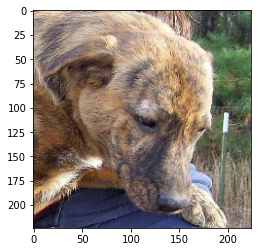

In [29]:
# importing cv2 
import cv2
  
# path
path = r'/content/dogs-vs-cats/test1/10000.jpg'
  
# Using cv2.imread() method
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(224,224))
plt.imshow(img)
img = np.reshape(img,(1,224,224,3))
img = img/255.
img = img.astype(np.float32)

# Displaying the image
print(type(img))
print(img.shape)

In [30]:
# Load model
sess = ort.InferenceSession("model_onnx/model.onnx")
input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name

# Inference result
result = sess.run([label_name], {input_name: img})

if(result[0] == 0):
  print("cat")
else:
  print("dog")
# Calculate accuracy
# count = 0
# for idx in range(len(y_test)):
#     count += 1 if y_test[idx] == predict[idx] else 0

# print("Test accuracy: ", count / len(y_test))

dog


In [31]:
result

[array([[1.]], dtype=float32)]